<a href="https://colab.research.google.com/github/hyunwoojang1/Projects/blob/main/Titanic_from_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

In [ ]:
uploaded=files.upload()

Saving test.csv to test (1).csv


In [ ]:
uploaded=files.upload()

Saving train.csv to train (1).csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
# Load data
#### Load train and Test set

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
IDtest=test['PassengerId']

In [ ]:
# Outlier detection

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices=[]

    # iterate over features(columns)
    for col in features:
      # 1st quartile (25%)
      Q1 = np.percentile(df[col],25) # 이러면 그 데이터의 25% 위치에 있는 값이 저장됨. 즉 그 value값 자체가 Q1에 저장되있음
      # 3rd quartile (75%)
      Q3 = np.percentile(df[col],75)
      IQR = Q3 - Q1

      # outlier step
      outlier_step=IQR * 1.5

      outlier_list_col=df[(df[col]< Q1-outlier_step) | (df[col]> Q3 +outlier_step)].index   # 이러면 outlier에 해당하는 value의 인덱스 즉 key값이 반환됨
      # append the found outlier indices for col to the list of outlier indices
      outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices=Counter(outlier_indices)
    multiple_outliers=list(k for k,v in outlier_indices.items() if v > n)

    return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
outliers_to_drop=detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

이 방법은 각 인덱스에서 몇개의 행에 outlier를 침범했냐를 물어보는거임

즉 outlier_indices = [2,5,7,3,5,8,5,3] 이렇게 나왔는데

Counter(outlier_indices)하면

Counter({5: 3, 3: 2, 2: 1, 7: 1, 8: 1})
이런 값이 나옴

여기에서 인덱스 5는 세번등장함 즉, 3개의 컬럼에서 outlier판정을 받은 아주 변칙적인 데이터임

보통 n값을 넣어서 이 n값보다 더 많은 컬럼에서 outlier판정을 받으면 그 인덱스를 반환 하는거임

즉 저기에서는 Age, SibSp, Parch, Fare중에서 두개보다 많은 outlier판정을 받은 인덱스를 반환 하는거임

In [ ]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28,89 and 342 passengers have an high Ticket Fare.

The 7 others have very high values of SibSP.

In [ ]:
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len=len(train)
dataset=pd.concat(objs=[train, test],axis=0).reset_index(drop=True)

예를 들어 train에는 sex = Male, Female 이렇게 있지만 test에는 sex= Male, Female, Non 이렇게 있을수도 있으니까 둘이 join해 두는거야 categrocial 정보를 알려고 할

In [ ]:
# Fill empty and NaNs values with NaN

dataset=dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,256
SibSp,0
Parch,0
Ticket,0
Fare,1


Age and Cabin features have an important part of missing values.

Survived missing values corresponding to the join testing dataset(Survived columns doens't exist in test set and has been replace by NaN values when concatenating the train and test set)

In [ ]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,170
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [ ]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


기본적으로 train.descibe() 는 수치형 데이터만 요약한다. 즉 int, float같은 데이터만 요약 하고 object같은 카테고리 값은 요약하지 않음

# 3 Feature analysis

# 3.1 Numerical values

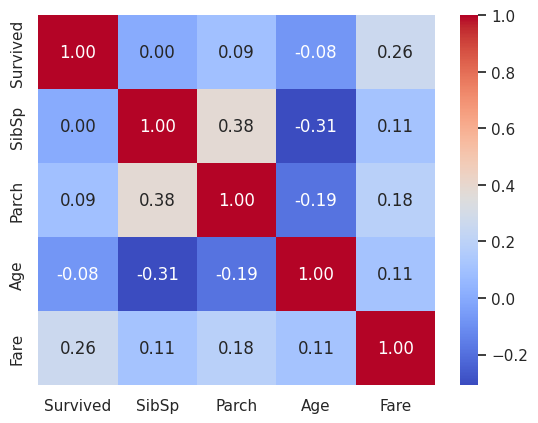

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived

g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Only Fare feature seems to have a significantive correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.

**SibSP**

<ipython-input-92-f51d7e1fd7b4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")


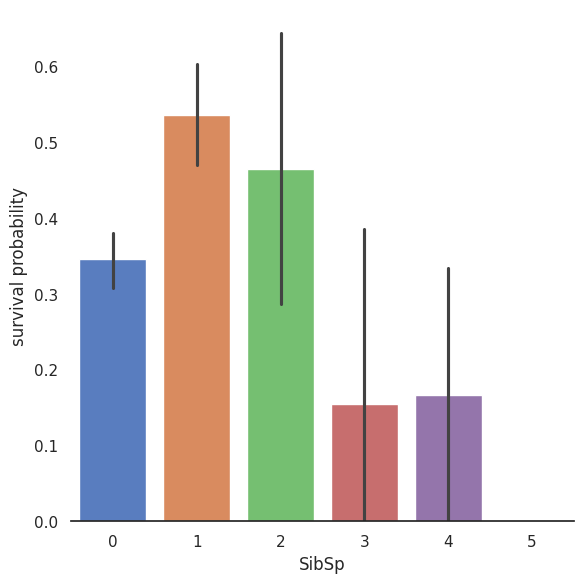

In [ ]:
# Explore SibSp feature vs Survived

g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of sibilngs/spouses have less chance to survive

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

**PARCH**

<ipython-input-93-9292044f6cc5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Parch",y="Survived", data=train, kind='bar', height=6, palette='muted')


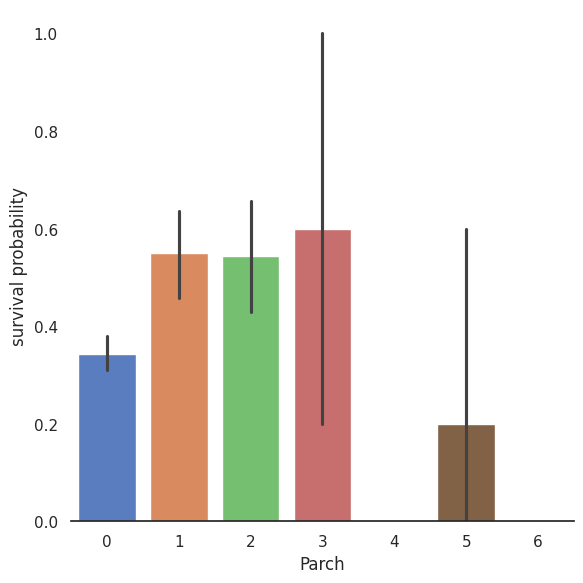

In [ ]:
# Explore Parch vs Survived

g = sns.catplot(x="Parch",y="Survived", data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children

**Age**

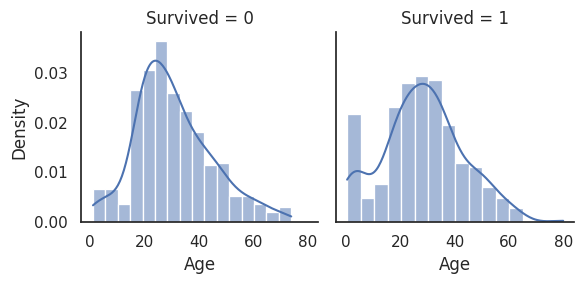

In [ ]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Age", kde=True,stat="density")

Even if 'Age' is not correlated with 'Survived', we can see that there is age categories of passengers that of have more or less chance to survive

It seems that very young passengers have more chance to survive

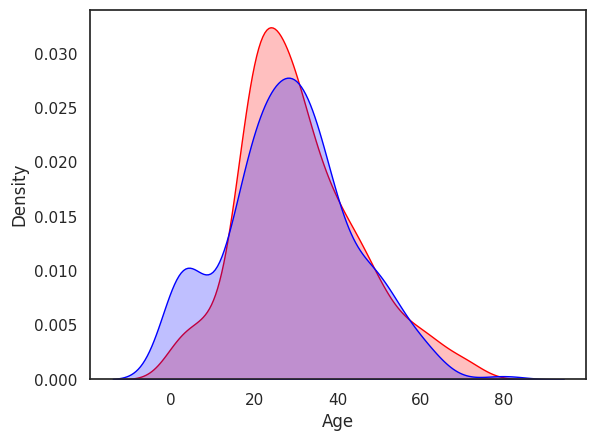

In [ ]:
# Explore Age distribution

g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color="Red",fill=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color='Blue',fill=True)

sns.kdeplot()은 어떤 그래프를 그릴까?
kdeplot()은 "커널 밀도 추정(Kernel Density Estimation, KDE)" 그래프를 그리는 함수야! 📊

🔹 KDE(커널 밀도 추정)란?
우리가 데이터를 보면, 어떤 값이 많이 등장하는지 궁금할 때가 있어.
예를 들어 타이타닉 승객의 나이를 본다고 해보자.

histplot()은 데이터를 막대그래프(히스토그램) 로 표현해. 📊
하지만 데이터가 너무 적으면 막대가 울퉁불퉁 할 수 있어.
그래서 滑らか하게(부드럽게) 데이터의 분포를 예측하는 방법이 "KDE" 야! 🌊
🔹 sns.kdeplot()이 하는 일
kdeplot()은 히스토그램을 부드럽게 연결해서 곡선으로 나타내는 그래프야!
즉, 데이터의 분포를 좀 더 직관적으로 볼 수 있도록 도와줘! 👀

When we superimpose the two densities, we cleary see a peak corresponding (between 0 and 5) to babies and very young childerns.

**Fare**

In [ ]:
dataset['Fare'].isnull().sum()

1

In [ ]:
dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())

Since we have one missing value, I decided to fill it with the median value which will not have an important effect on the prediction

<ipython-input-98-02402b92c0eb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color='m', label="skewness : %.2f"%(dataset['Fare'].skew()))


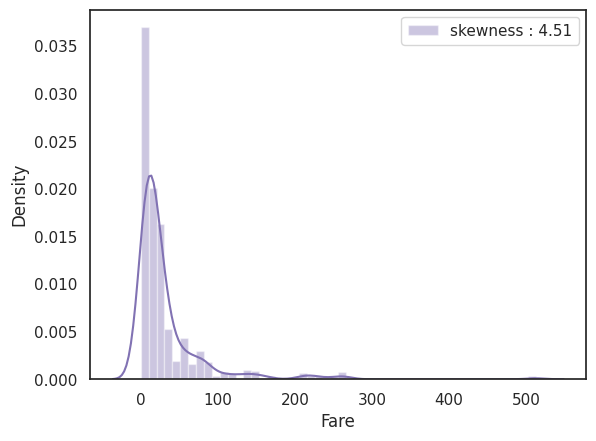

In [ ]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color='m', label="skewness : %.2f"%(dataset['Fare'].skew()))
g = g.legend(loc='best')

As we can see, Fare distribution is very skewed. This can lead to overweight very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [ ]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare']= dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

<ipython-input-100-497e31000018>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color='b', label="skewness : %.2f"%(dataset['Fare'].skew()))


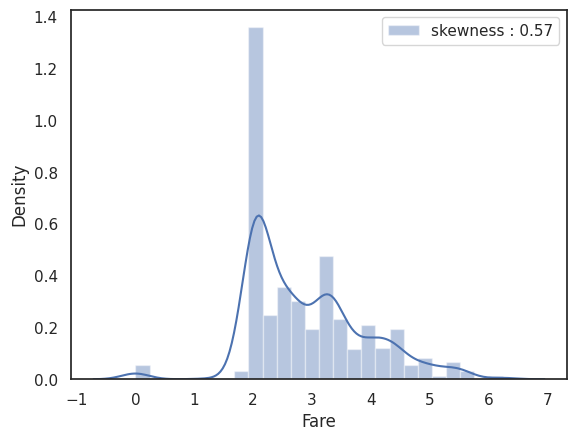

In [ ]:
g = sns.distplot(dataset['Fare'], color='b', label="skewness : %.2f"%(dataset['Fare'].skew()))
g = g.legend(loc='best')

Skewness is clearly reduced after the log transformation

# 3.2 Categorical values

**Sex**

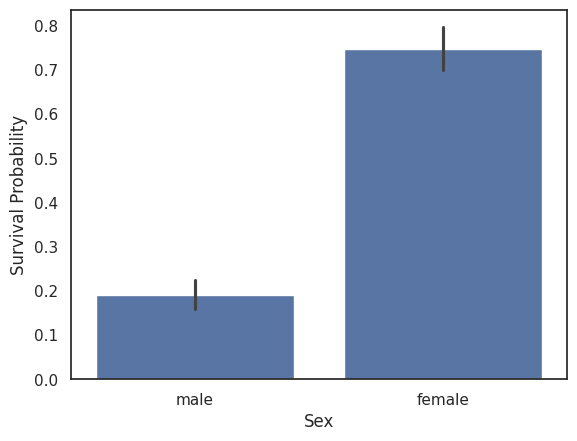

In [ ]:
g = sns.barplot(x='Sex',y='Survived', data= train)
g = g.set_ylabel('Survival Probability')

In [ ]:
train[["Sex","Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female.

So Sex, might play an important role in the prediction of the survival.

For those who have seen the Titanic movie (1997), I am sure, we all remember this sentence during the evacuation :"Women and children first".

**Pclass**

<ipython-input-103-dfad736a017d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Pclass',y='Survived',data=train, kind='bar', height=6 , palette='muted')


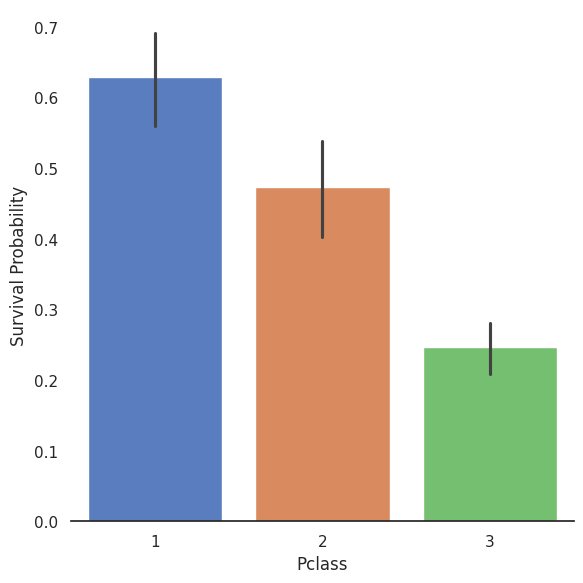

In [ ]:
# Explore Pclass vs Survived

g = sns.catplot(x='Pclass',y='Survived',data=train, kind='bar', height=6 , palette='muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

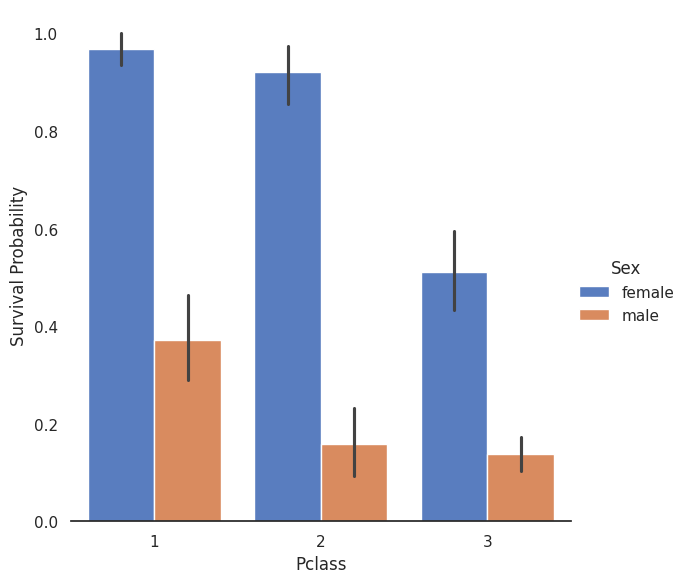

In [ ]:
g = sns.catplot(x='Pclass',y='Survived',hue='Sex',data=train, kind='bar', height=6 , palette='muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conseved when we look at both male and female passnegers.

In [ ]:
train['Embarked'].isnull().sum()

2

In [ ]:
train['Embarked'].describe()

,Embarked
count,879
unique,3
top,S
freq,634


In [ ]:
train['Embarked']=train['Embarked'].fillna(train['Embarked'].mode()[0])

📌 mode()는 최빈값이 여러 개일 경우 리스트 형태로 반환하므로, [0]을 붙여 첫 번째 값을 가져오는 것!

<ipython-input-108-220ecc683037>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Embarked',y='Survived', data=train, kind='bar', height=6, palette= 'muted')


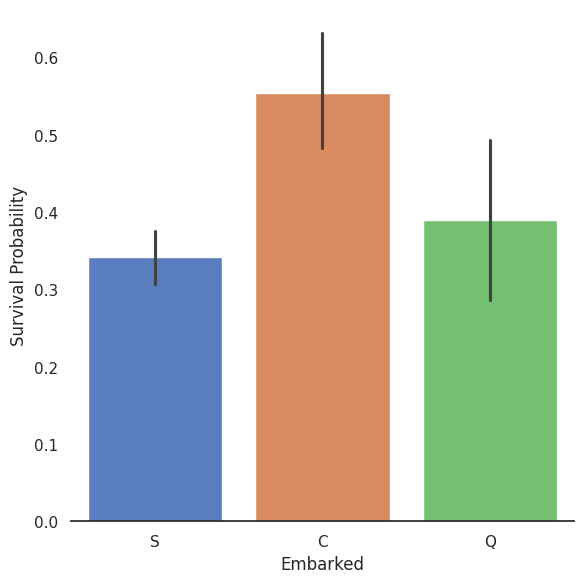

In [ ]:
g = sns.catplot(x='Embarked',y='Survived', data=train, kind='bar', height=6, palette= 'muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown(Q),and Southampton (S).

<ipython-input-109-c7c583d7ca41>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Pclass',col='Embarked',data=train, kind='count', height=6, palette= 'muted')


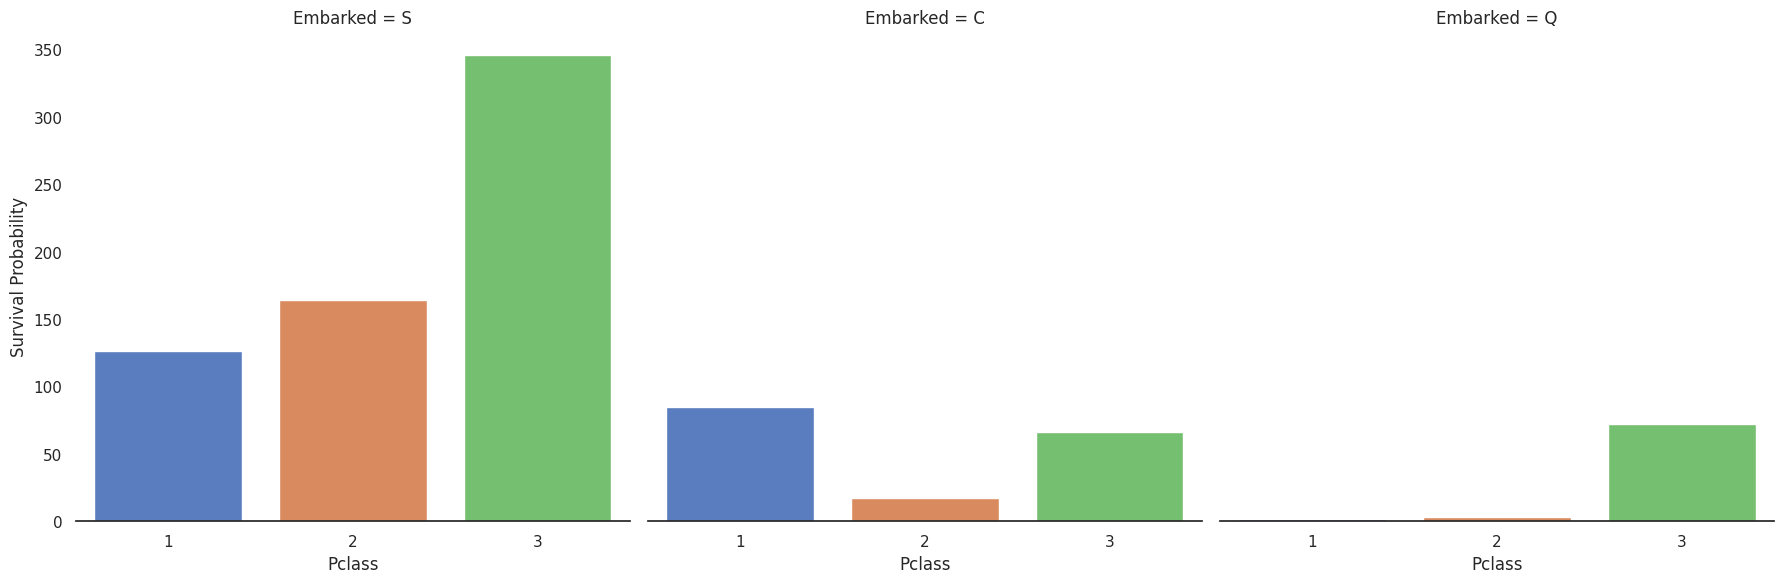

In [ ]:
g = sns.catplot(x='Pclass',col='Embarked',data=train, kind='count', height=6, palette= 'muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

At this point. i can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

# 4. Filling missing Values

## 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (childeren for exmaple), it is preferable to keep the age feature and to impute the missing values.

To address this problem, I looked at the most correlated features with Age (Sex, Parch, Pclass, and SibSP).

즉 중요한 데이터 column을 유추하기 위해 다른 column을 확인해서 유사성을 보는것

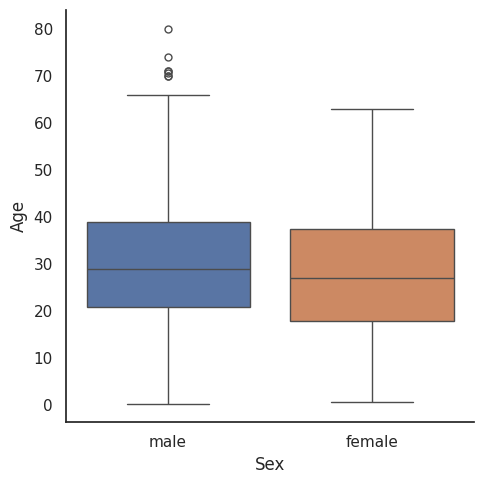

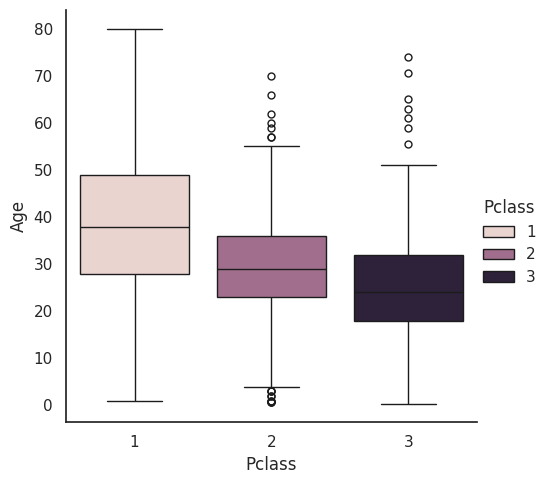

In [ ]:
# Explore Age vs Sex, Parch, Pclass and SibSP

g = sns.catplot(y = 'Age', x = 'Sex', data = train, kind = 'box', hue = 'Sex')
g = sns.catplot(y = 'Age', x = 'Pclass', data = train, kind = 'box', hue = 'Pclass')

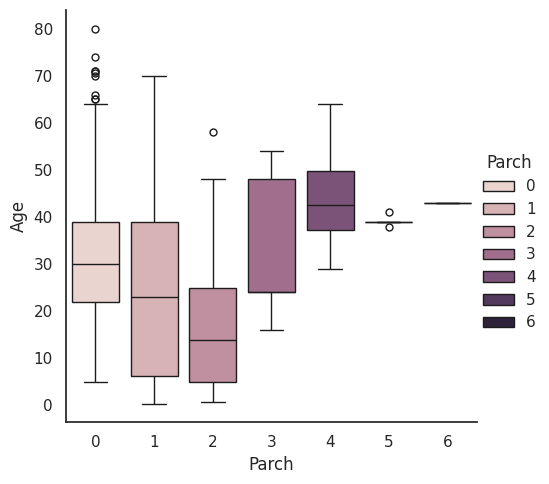

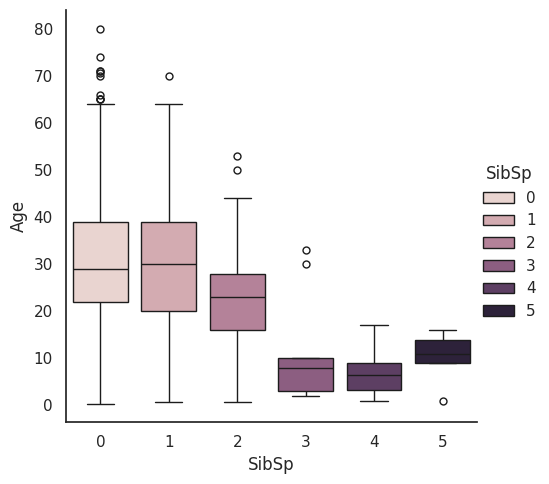

In [ ]:
g = sns.catplot(y = 'Age', x = 'Parch', data = train, kind = 'box', hue = 'Parch')
g = sns.catplot(y = 'Age', x = 'SibSp', data = train, kind = 'box', hue = 'SibSp')

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [ ]:
# Convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})

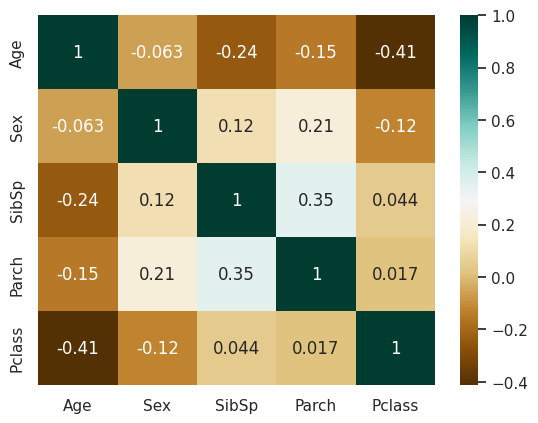

In [ ]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(), cmap = 'BrBG', annot = True)

✔ sns.heatmap()은 데이터의 상관관계(correlation) 행렬을 시각화하는 함수야.

✔ 색깔로 상관관계를 표현해서 변수 간의 관계를 쉽게 파악할 수 있어.

✔ .corr()는 상관계수(correlation coefficient)를 계산하는 함수야.

✔ 이걸 실행하면 변수들끼리 얼마나 관련이 있는지 -1 ~ 1 사이의 값으로 반환해.

🔹 상관계수 해석

1 (또는 +에 가까움): 강한 양의 상관관계 (한 변수가 증가하면 다른 변수도 증가)

0: 상관관계 없음

-1 (또는 -에 가까움): 강한 음의 상관관계 (한 변수가 증가하면 다른 변수는 감소)

✅ 4. cmap='BrBG' (컬러맵)

✔ cmap은 히트맵의 색상 테마를 정하는 옵션이야.

✔ 'BrBG'는 갈색-청록색(Brown-BlueGreen) 컬러맵을 의미해. ✔ 색상에 따라 상관관계가 어떻게 분포되는지 쉽게 볼 수 있어.

✅ 5. annot=True (숫자 표시)
✔ 히트맵 위에 상관계수 숫자를 표시할지 여부를 정하는 옵션이야.

✔ True로 설정하면 각 셀에 상관계수 숫자가 표시됨.

✔ False로 하면 숫자는 안 나오고 색깔만 보여줘.

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.

So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [ ]:
# Filling missing value of Age

## Fill Age with the median age of similar rows accroding to Pclass, Parch and SibSp

# Index of NaN age rows

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) &
                               (dataset['Parch'] == dataset.iloc[i]["Parch"]) &
                               (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()

  # age_prep가 NaN이 아니면 age_pred로 Age 값을 대체, NaN이면 전체 중앙값으로
  if not np.isnan(age_pred):
    dataset.loc[i, 'Age'] = age_pred
  else:
    dataset.loc[i, 'Age'] = age_med


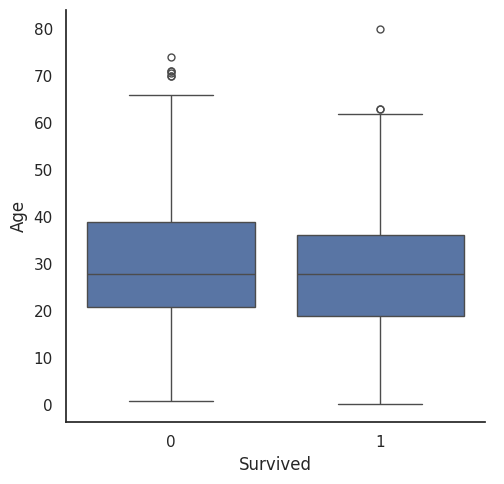

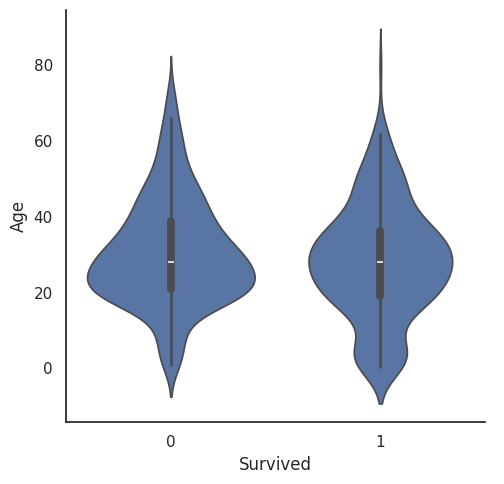

In [ ]:
g = sns.catplot( x = 'Survived', y = 'Age', data = train, kind = 'box')
g = sns.catplot( x = 'Survived', y = 'Age', data = train, kind = 'violin')

No difference between median value of age in survived and not survived subpoplulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate

# 5. Feature Engineering

## 5.1 Name/Title

In [ ]:
dataset['Name'].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


The Name feature contains information on passenger's title.

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [ ]:
# Get Title from Name


dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]

dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

,Title
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr


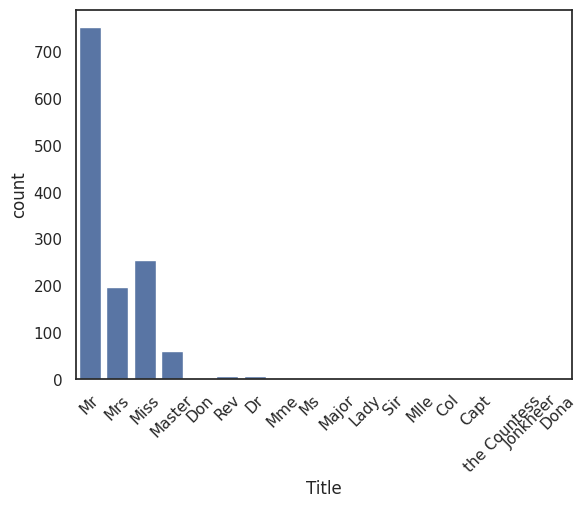

In [ ]:
g = sns.countplot( x = 'Title',data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories

In [ ]:
# Conver to categorical value Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)


<ipython-input-120-2950c1f2eac3>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])


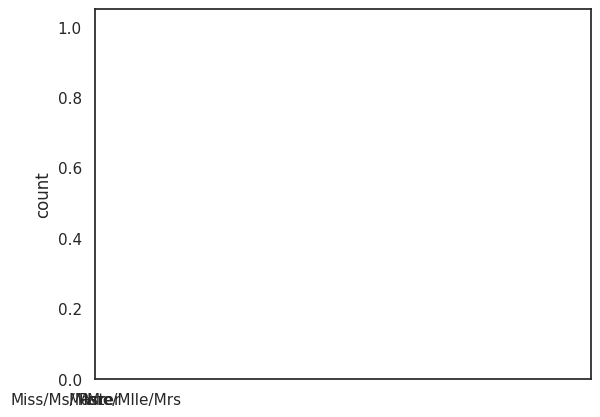

In [ ]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

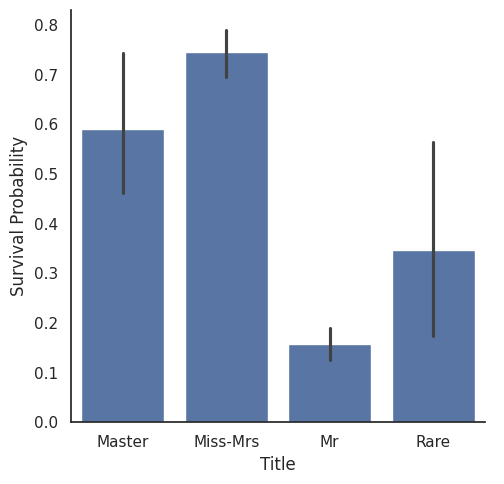

In [ ]:
g = sns.catplot(x='Title', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('Survival Probability')

In [ ]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

## Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/partents during the evacuation. So I choosed to create a 'Fize' (family size) featrue which is sum of SibSp, Parch, and 1 (including the passenger).

In [ ]:
# Create a family size descriptor from Sibsp and Parch

dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

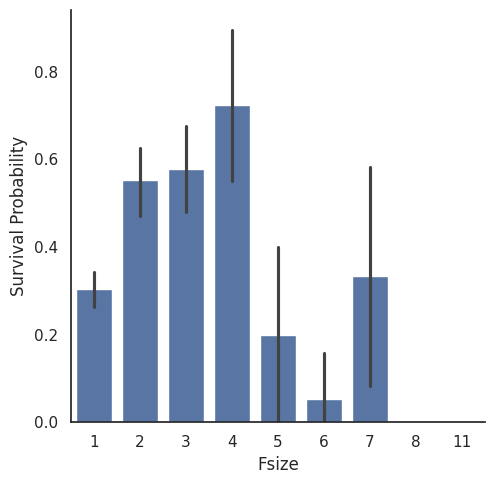

In [ ]:
g = sns.catplot(x = 'Fsize', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

The family size seems to play an important role, survival probability is worst for large families.

Additionally, I decided to created 4 categories of family size

In [ ]:
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s ==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s:1 if s ==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s:1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s >= 5 else 0)

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,S,2,2,0,1,0,0
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,C,1,2,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,1,1,0,0,0
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,S,1,2,0,1,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,S,2,1,1,0,0,0


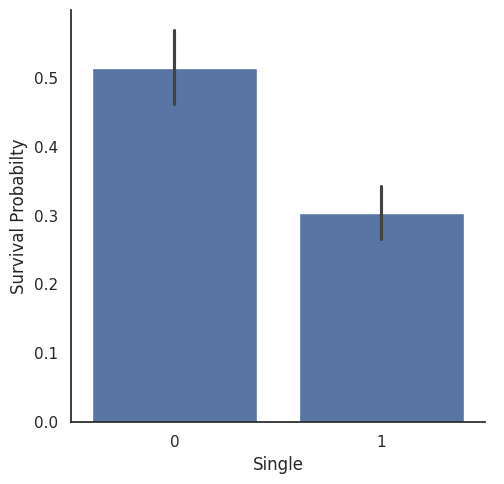

In [ ]:
g = sns.catplot(x = 'Single', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probabilty')

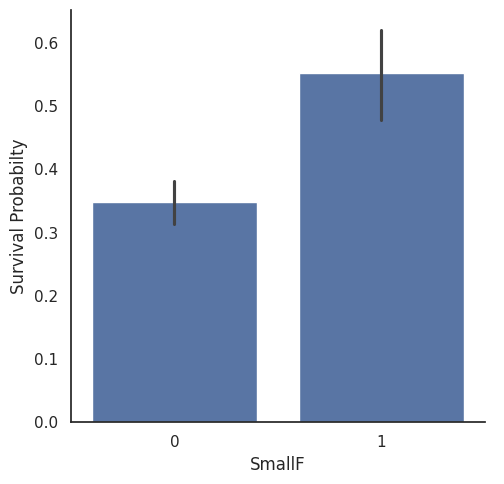

In [ ]:
g = sns.catplot(x = 'SmallF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probabilty')

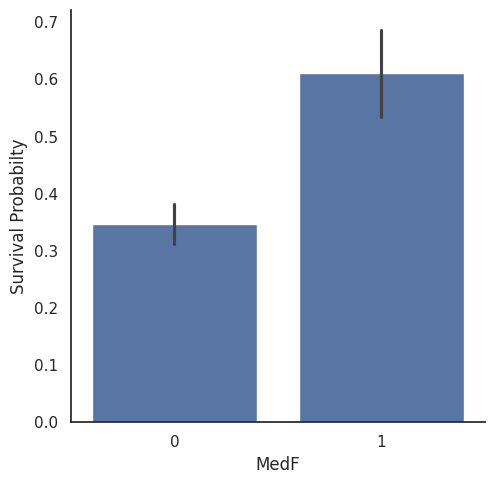

In [ ]:
g = sns.catplot(x = 'MedF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probabilty')

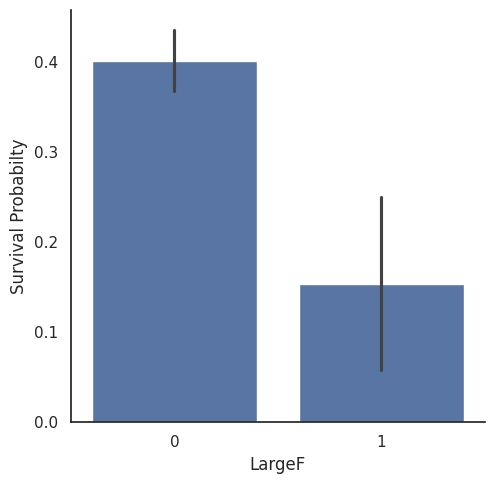

In [ ]:
g = sns.catplot(x = 'LargeF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probabilty')

Catplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families

In [ ]:
# conver to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ['Title']).astype(int)
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em').astype(int)


KeyError: "None of [Index(['Title'], dtype='object')] are in the [columns]"

In [ ]:
cols_to_convert = ['Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S']
dataset[cols_to_convert] = dataset[cols_to_convert].astype(int)


In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [ ]:
dataset['Cabin'].head()

,Cabin
0,NaN
1,C85
2,NaN
3,C123
4,NaN


In [ ]:
dataset['Cabin'].describe()

,Cabin
count,292
unique,186
top,G6
freq,5


In [ ]:
dataset['Cabin'].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.

I supposed that passengers without a cabin have a missing value displayed instead of the cabin number

In [ ]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

,Cabin
1,C85
3,C123
6,E46
10,G6
11,C103


In [ ]:
dataset['Cabin'][dataset['Cabin'].notnull()].describe()

,Cabin
count,292
unique,186
top,G6
freq,5


In [ ]:
# Replace the cabin number by the type of cabin 'X' if not

dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

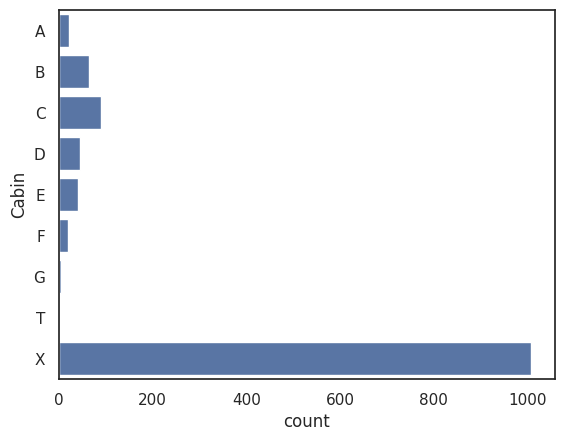

In [ ]:
g = sns.countplot(dataset['Cabin'], order = ['A','B','C','D','E','F','G','T','X'])

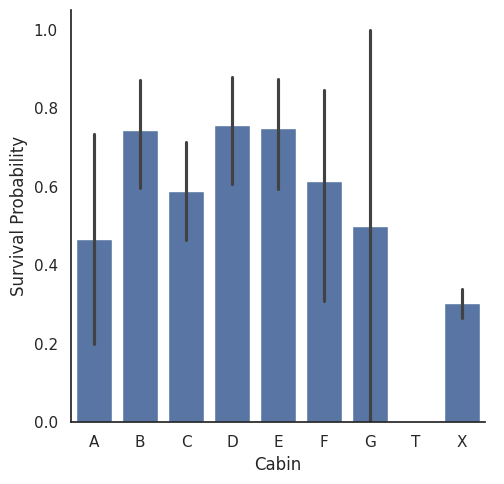

In [ ]:
g = sns.catplot( x = 'Cabin', y = 'Survived', data = dataset, kind = 'bar', order = ['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B,C,D,E and F.

In [ ]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = "Cabin")

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,False,False,False,False,False,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,False,False,True,False,False,False,False,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,False,False,False,False,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,False,False,True,False,False,False,False,False,False
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,False,False,False,False,False,False,False,False,True


In [ ]:
cols_to_convert = ['Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X']
dataset[cols_to_convert] = dataset[cols_to_convert].astype(int)

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


## 5.4 Ticket

In [ ]:
dataset['Ticket'].head()

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450


It could mean that tickets sharing the same prefixeds could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So I decided to replace the Tickey feature column by the ticket prefixe. Which my be more informative

In [ ]:
dataset['Ticket'].describe()

,Ticket
count,1299
unique,929
top,CA 2144
freq,8


In [ ]:
## Treat Ticket by extracting the tickey prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
  else:
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()


,Ticket
0,A5
1,PC
2,STONO2
3,X
4,X


In [ ]:
dataset['Ticket'] = dataset['Ticket'].astype('category')

In [ ]:
dataset['Ticket'].describe()

,Ticket
count,1299
unique,37
top,X
freq,954


In [ ]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,1,0.0,3,0,22.0,1,0,1.981001,2,0,...,False,False,False,False,False,False,False,False,False,False
1,2,1.0,1,1,38.0,1,0,4.266662,2,0,...,False,False,False,False,False,False,False,False,False,False
2,3,1.0,3,1,26.0,0,0,2.070022,1,1,...,False,False,False,False,True,False,False,False,False,False
3,4,1.0,1,1,35.0,1,0,3.972177,2,0,...,False,False,False,False,False,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,2.085672,1,1,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
dataset.shape

(1299, 66)

In [ ]:
col = dataset.columns.tolist()
col

['PassengerId',
 'Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Fsize',
 'Single',
 'SmallF',
 'MedF',
 'LargeF',
 'Title_0',
 'Title_1',
 'Title_2',
 'Title_3',
 'Em_C',
 'Em_Q',
 'Em_S',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_X',
 'T_A',
 'T_A4',
 'T_A5',
 'T_AQ3',
 'T_AQ4',
 'T_AS',
 'T_C',
 'T_CA',
 'T_CASOTON',
 'T_FC',
 'T_FCC',
 'T_Fa',
 'T_LINE',
 'T_LP',
 'T_PC',
 'T_PP',
 'T_PPP',
 'T_SC',
 'T_SCA3',
 'T_SCA4',
 'T_SCAH',
 'T_SCOW',
 'T_SCPARIS',
 'T_SCParis',
 'T_SOC',
 'T_SOP',
 'T_SOPP',
 'T_SOTONO2',
 'T_SOTONOQ',
 'T_SP',
 'T_STONO',
 'T_STONO2',
 'T_STONOQ',
 'T_SWPP',
 'T_WC',
 'T_WEP',
 'T_X']

In [ ]:
dataset.loc[:, dataset.columns.str.startswith('T_')] = dataset.loc[:, dataset.columns.str.startswith('T_')].astype(int)

<ipython-input-172-ad16c6c58523>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.loc[:, dataset.columns.str.startswith('T_')] = dataset.loc[:, dataset.columns.str.startswith('T_')].astype(int)
<ipython-input-172-ad16c6c58523>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.loc[:, dataset.columns.str.startswith('T_')] = dataset.loc[:, dataset.columns.str.startswith('T_')].astype(int)
<ipython-input-172-ad16c6c58523>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a com

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,1,0.0,3,0,22.0,1,0,1.981001,2,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,38.0,1,0,4.266662,2,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,2.070022,1,1,...,0,0,0,0,1,0,0,0,0,0
3,4,1.0,1,1,35.0,1,0,3.972177,2,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,2.085672,1,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [ ]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,False,False,True
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,True,False,False
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,False,False,True
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,True,False,False
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,False,False,True


In [ ]:
col_to_convert = ['Pc_1','Pc_2','Pc_3']
dataset[col_to_convert] = dataset[col_to_convert].astype(int)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. MODELING

In [ ]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

<ipython-input-180-29ec040f16a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels = ['Survived'], axis = 1, inplace = True)


In [ ]:
## Separate train features and label

train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis = 1)

<ipython-input-181-4627bea007f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived'] = train['Survived'].astype(int)


## 6.1 Simple modeling

### 6.1.1 Cross Validate models

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

SVC

Decision Tree

AdaBoost

Random Forest

Extra Trees

Gradient Boosting

Multiple layer perceptron (neural network)

KNN

Logistic regression

Linear Discriminant Analysis

In [ ]:
# Cross validate model with Kfold stratified cross val

kfold = StratifiedKFold(n_splits = 10)

<ipython-input-195-c38f0d576b92>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h")


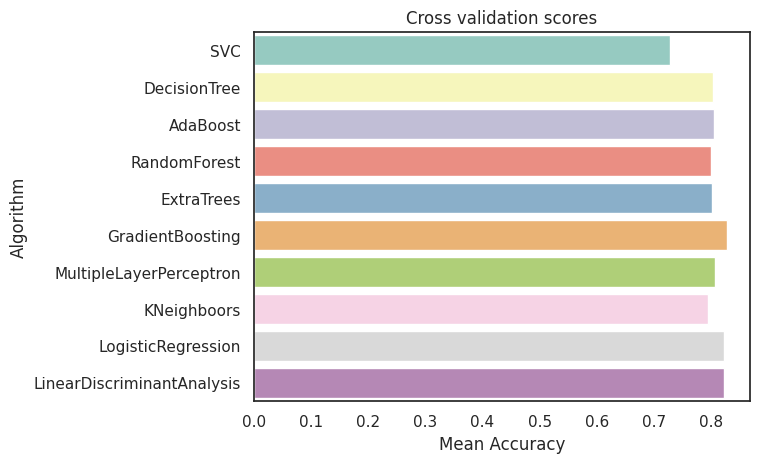

In [ ]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std, "Algorithm":["SVC","DecisionTree","AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors", "LogisticRegression", "LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h")
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [ ]:
print(cv_res.shape)

(10, 3)


In [ ]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.727617,0.041014,SVC
1,0.803728,0.038004,DecisionTree
2,0.804877,0.051141,AdaBoost
3,0.800255,0.046489,RandomForest
4,0.802541,0.043532,ExtraTrees
5,0.827464,0.041550,GradientBoosting
6,0.808184,0.033031,MultipleLayerPerceptron
7,0.794574,0.039706,KNeighboors
8,0.822932,0.033765,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis
